<h1 align=center><font size=5>Speech Recognition</font></h1>

## Table of contents

- [Objective](#obj)
- [Data](#data)
- [Data Preprocessing](#data_preproc)
- [Time Domain Model](#time_model)
- [Time-Frequency Domain Model](#time_freq_model)

## Objective <a id='obj'></a>

In this notebook, we will learn how to deal with audio/voice singals. Accordingly, we will build time domain and time-frequency domain models for the purpose of speech classification.

## Data <a id='data'></a>

Let us consider the Free Spoken Digit Dataset (FSDD), so called "speech MNIST" dataset. The dataset contains a set of recorded spoken digits in wav formats. You can access to this dataset in the following URL: https://github.com/Jakobovski/free-spoken-digit-dataset

&#x270d; Download the dataset

In [ ]:
!rm -rf free-spoken-digit-dataset-master master.zip
!wget https://github.com/Jakobovski/free-spoken-digit-dataset/archive/master.zip
!unzip -q -o master.zip
!rm master.zip

--2020-03-09 08:42:29--  https://github.com/Jakobovski/free-spoken-digit-dataset/archive/master.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/master [following]
--2020-03-09 08:42:29--  https://codeload.github.com/Jakobovski/free-spoken-digit-dataset/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [    <=>             ]   9.03M  12.4MB/s    in 0.7s    

2020-03-09 08:42:30 (12.4 MB/s) - ‘master.zip’ saved [9465583]



In [ ]:
# on google colab
from google.colab import drive
drive.mount('/content/gdrive')

path_clone = "/content/gdrive/My Drive/projects"
!cd path_clone 

!git colab https://github.com/Jakobovski/free-spoken-digit-dataset.git 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/bin/bash: line 0: cd: path_clone: No such file or directory
git: 'colab' is not a git command. See 'git --help'.

The most similar command is
	clone


&#x270d; Load an audio file using librosa.load. To preserve the native sampling rate of the file, use `sr=None`.

In [ ]:
import os
import librosa # !pip install librosa


audio_path = os.path.join(os.getcwd(), 'free-spoken-digit-dataset-master/recordings')
audio_files = os.listdir(audio_path) 

sample_audio_file = audio_files[500] # choose a ranodm audio file

sample_audio_path = audio_path + '/' + sample_audio_file


X, sr = librosa.load(sample_audio_path, sr= None)

&#x270d; Display the length of the audio array and sampling rate.

In [ ]:
print('Audio signal shape:', X.shape)
print('Sampling rate: {} Hz'.format(sr))

Audio signal shape: (5711,)
Sampling rate: 8000 Hz


&#x270d; How long is the audio signal in seconds?

In [ ]:
print('Audio length: {} seconds'.format(X.shape[0]/sr))

Audio length: 0.713875 seconds


&#x270d; Play your chosen audio file.

In [ ]:
from IPython.display import Audio

Audio(X, rate = sr)

&#x270d; Plot the audio signal in time domain.

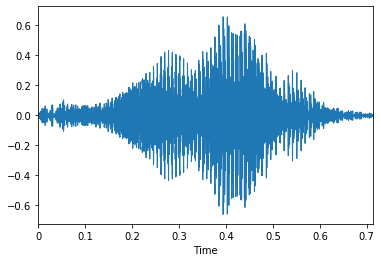

In [ ]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

librosa.display.waveplot(X, sr= sr)

&#x270d; Display the audio signal's spectrogram on a logarithmic scale using *librosa.stft*. Note that, the Short-Time Fourier Transform (STFT) represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

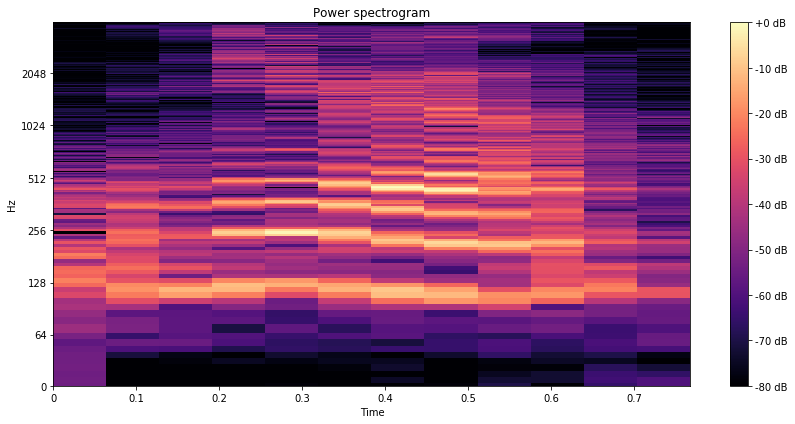

In [ ]:
import numpy as np

n_fft = 1024
hop_length = 512

stft = librosa.stft(X, n_fft= n_fft, hop_length= hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_dB = librosa.amplitude_to_db(stft_magnitude, ref= np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_dB, 
                         x_axis='time', y_axis='log', 
                         sr= sr, hop_length= hop_length)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

&#x270d; What is the hop length in seconds?

In [ ]:
print('Hop length: {} seconds'.format(hop_length/sr)) 

Hop length: 0.064 seconds


## Data Preprocessing <a id='data_preproc'></a>

&#x270d; Find all audio files duration in seconds and sampling rate, and plot their distributions.

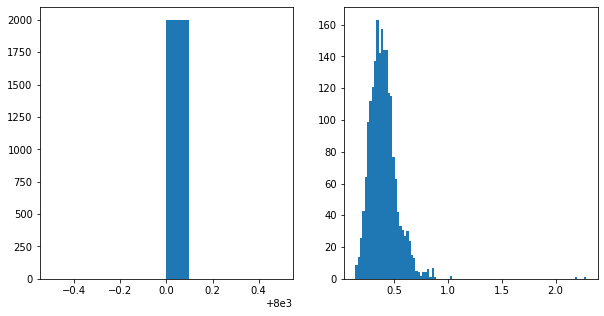

In [ ]:
audio_path = os.path.join(os.getcwd(), 'free-spoken-digit-dataset-master/recordings')
audio_files = os.listdir(audio_path) 

all_audios_sr = []
all_audios_duration = []
for audio_file in audio_files:
    
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    
    all_audios_sr.append(sr)
    all_audios_duration.append(len(audio)/sr)

all_audios_duration = np.asarray(all_audios_duration)
all_audios_sr = np.asarray(all_audios_sr)

plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.hist(all_audios_sr);

plt.subplot(1,2,2)
plt.hist(all_audios_duration, bins = 100);

&#x270d; Clip or pad audio signals to have one second duration for all audios. Extract audio labels as well. Keep audio signals from speaker 'jackson' for test set, and the rest speakers for training.

In [ ]:
audio_duration_sec = 1

pad = lambda a, n: a[:n] if a.shape[0] > n else np.hstack((a, np.zeros(n - a.shape[0])))

X_train, y_train = [], []
X_test, y_test = [], []
for audio_file in audio_files:
    
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    
    X = pad(audio, int(audio_duration_sec*sr))
    label = audio_file.split('_')[0]
    speaker = audio_file.split('_')[1]
    
    if (speaker=='jackson'):
        X_test.append(X)
        y_test.append(label)
    else:
        X_train.append(X)
        y_train.append(label)
        
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1500, 8000)
X_test shape: (500, 8000)


In [ ]:
X_train

&#x270d; Convert the labels to a one-hot vector. 

In [ ]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Using TensorFlow backend.


In [ ]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (1500, 10)
y_test shape: (500, 10)


## Time Domain Model <a id='time_model'></a>

&#x270d; Build a model based on time domain input signals and evaluate the classification performance of it. 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, activation='relu', input_dim= X_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2048256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_

In [ ]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics= ['accuracy'])

history = model.fit(X_train, y_train,
          epochs= 100,
          batch_size= 64,
          validation_split = 0.2,
          shuffle = True,
          verbose = 1)

Train on 1200 samples, validate on 300 samples
Epoch 1/100
1200/1200 [==============================] - 1s 1ms/step - loss: 0.0128 - acc: 0.9967 - val_loss: 7.5773 - val_acc: 0.2000
Epoch 2/100
1200/1200 [==============================] - 1s 673us/step - loss: 0.0219 - acc: 0.9975 - val_loss: 7.7045 - val_acc: 0.2067
Epoch 3/100
1200/1200 [==============================] - 1s 652us/step - loss: 0.0205 - acc: 0.9983 - val_loss: 7.6638 - val_acc: 0.2100
Epoch 4/100
1200/1200 [==============================] - 1s 652us/step - loss: 0.0149 - acc: 0.9975 - val_loss: 7.7489 - val_acc: 0.2133
Epoch 5/100
1200/1200 [==============================] - 1s 647us/step - loss: 0.0071 - acc: 1.0000 - val_loss: 7.7404 - val_acc: 0.2133
Epoch 6/100
1200/1200 [==============================] - 1s 671us/step - loss: 0.0264 - acc: 0.9950 - val_loss: 7.7511 - val_acc: 0.2233
Epoch 7/100
1200/1200 [==============================] - 1s 668us/step - loss: 0.0123 - acc: 0.9967 - val_loss: 7.6914 - val_acc: 0.2

In [ ]:
#history.history["acc"]

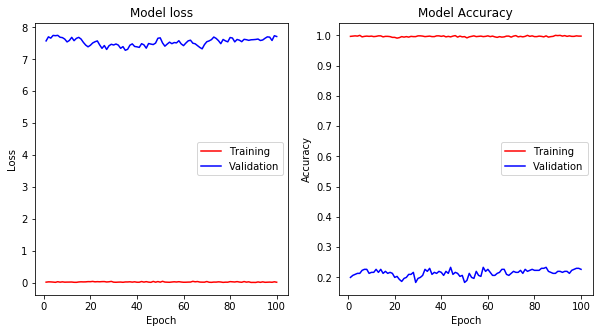

In [ ]:
def plot_model(history):
    tr_loss = history.history['loss']
    tr_accuracy = history.history['acc']

    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_acc']

    epochs = range(1, len(tr_loss)+1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_loss,'r')
    plt.plot(epochs, val_loss,'b')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')

    plt.subplot(1,2,2)
    plt.plot(epochs, tr_accuracy,'r')
    plt.plot(epochs, val_accuracy,'b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='best')
    plt.show()
    
plot_model(history)

In [ ]:
score, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 56.249474639892576
Test accuracy: 0.1599999964237213


## Time-Frequency Domain Model <a id='time_freq_model'></a>

&#x270d; Now, create a model based on time-frequency domain input signals and evaluate its performance.

In [ ]:
audio_path = os.path.join(os.getcwd(), 'free-spoken-digit-dataset-master/recordings')
audio_files = os.listdir(audio_path) 

X_train, y_train = [], []
X_test, y_test = [], []
for audio_file in audio_files:
    
    audio, sr = librosa.load(audio_path +'/'+ audio_file, sr = None)
    
    X = pad(audio, int(audio_duration_sec*sr))
    
    spectrogram = np.abs(librosa.stft(X))
    
    label = audio_file.split('_')[0]
    speaker = audio_file.split('_')[1]
    
    if (speaker=='jackson'):
        X_test.append(spectrogram)
        y_test.append(label)
    else:
        X_train.append(spectrogram)
        y_train.append(label)
        
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1500, 1025, 16, 1)
X_test shape: (500, 1025, 16, 1)


In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (1500, 10)
y_test shape: (500, 10)


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', input_shape= X_train[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1023, 14, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 511, 7, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 511, 7, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 509, 5, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 254, 2, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 254, 2, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32512)            

In [ ]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= 'adam',
              metrics= ['accuracy'])

history = model.fit(X_train, y_train,
          epochs= 15,
          batch_size= 64,
          validation_split = 0.2,
          shuffle = True,
          verbose = 1)

Train on 1200 samples, validate on 300 samples
Epoch 1/15
1200/1200 [==============================] - 21s 18ms/step - loss: 1.7566 - acc: 0.4042 - val_loss: 1.0252 - val_acc: 0.7500
Epoch 2/15
1200/1200 [==============================] - 20s 17ms/step - loss: 1.0388 - acc: 0.6775 - val_loss: 0.5626 - val_acc: 0.8467
Epoch 3/15
1200/1200 [==============================] - 20s 17ms/step - loss: 0.7411 - acc: 0.7558 - val_loss: 0.4810 - val_acc: 0.8400
Epoch 4/15
1200/1200 [==============================] - 20s 17ms/step - loss: 0.6089 - acc: 0.8100 - val_loss: 0.3489 - val_acc: 0.9333
Epoch 5/15
1200/1200 [==============================] - 20s 17ms/step - loss: 0.4767 - acc: 0.8608 - val_loss: 0.3155 - val_acc: 0.9100
Epoch 6/15
1200/1200 [==============================] - 21s 17ms/step - loss: 0.3984 - acc: 0.8825 - val_loss: 0.2705 - val_acc: 0.9133
Epoch 7/15
1200/1200 [==============================] - 21s 17ms/step - loss: 0.3930 - acc: 0.8792 - val_loss: 0.3235 - val_acc: 0.8967
E

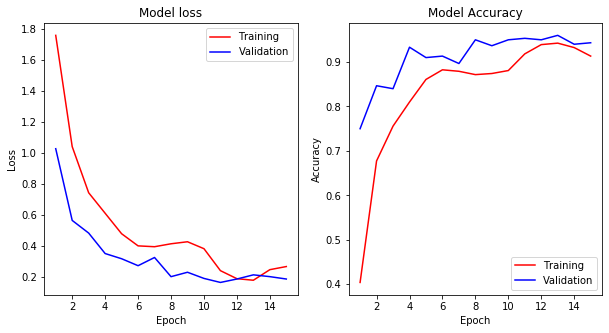

In [ ]:
plot_model(history)

In [ ]:
score, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 6.4804953079223635
Test accuracy: 0.5379999995231628
